In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shap_flow_util import get_mean_shap_attr

import xgboost as xgb

import dill
import datetime
from shap_flow_util import plot_dependency, read_csv_incl_timeindex

import torch
from PriceFNN import PriceFNN
from shap_flow_util import read_csv_incl_timeindex, plot_dependency
from sklearn.preprocessing import MinMaxScaler

from shap_flow_util import plot_beeswarm, rename_nodes_in_graph_FR

# Data Plots

In [2]:
file_path = './data/data_scm_FR_2015-2024.csv'
data = pd.read_csv(file_path)

In [3]:
data.columns

Index(['timestamp', 'price_da', 'carbon_price', 'gas_price', 'oil_price',
       'solar_da', 'wind_off_da', 'wind_on_da', 'load_da', 'load',
       'nuclear_unavail', 'nuclear_cap', 'nuclear_avail', 'generation_da',
       'biomass_gen', 'gas_gen', 'hard_coal_gen', 'hard_coal_cons', 'oil_gen',
       'hydro_storage_gen', 'hydro_storage_cons', 'run_off_gen',
       'run_off_cons', 'hydro_reservoir_gen', 'hydro_reservoir_cons',
       'nuclear_gen', 'solar_gen', 'waste_gen', 'wind_off_gen',
       'wind_off_cons', 'wind_on_gen', 'temp_paris', 'temp_marseille',
       'temp_lyon', 'temp_toulouse', 'temp_nice', 'temp_nantes',
       'temp_strasbourg', 'temp_montpellier', 'temp_bordeaux', 'temp_lille',
       'temp_mean', 'FR<-BE', 'FR<-CH', 'FR<-DE_AT_LU', 'FR<-DE_LU', 'FR<-ES',
       'FR<-GB', 'FR<-IT_NORD', 'FR<-IT_NORD_FR', 'solar_da_ramp',
       'wind_off_da_ramp', 'wind_on_da_ramp', 'load_da_ramp', 'ramperation_da',
       'biomass_ramp', 'gas_ramp', 'hard_coal_ramp', 'oil_ramp',
  

In [4]:
data.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
data.rename(columns={'ramperation_da': 'generation_da_ramp'}, inplace=True)
seed = 0

version = 'v5'

data.index = pd.to_datetime(data['timestamp'])# add timestamp index

# add moving average temp of last 7 days
data['temp_mean_7d_avg'] = data['temp_mean'].rolling('7d').mean()

# add total wind_da and wind_da_ramp as columns
#data['wind_da'] = data['wind_on_da'] + data['wind_off_da'].fillna(value=0)
#data['wind_da_ramp'] = data['wind_on_da_ramp'] + data['wind_off_da_ramp'].fillna(value=0)

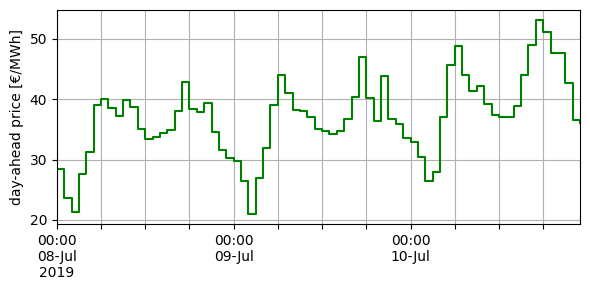

In [6]:
g = data['price_da']['2019-07-08':'2019-07-10'].plot(figsize=(6, 3), 
                                                     drawstyle='steps-post', 
                                                     xlabel='', 
                                                     ylabel='day-ahead price [€/MWh]', 
                                                     color='green',
                                                     grid=True)
xticks = pd.date_range(start='2019-07-08', end='2019-07-10 18:00', freq='6H')
g.set_xticks(xticks)
plt.tight_layout()
plt.savefig('./plots/da_price_example.svg')
plt.show()
# TODO: more time steps (every 6 hours at least)

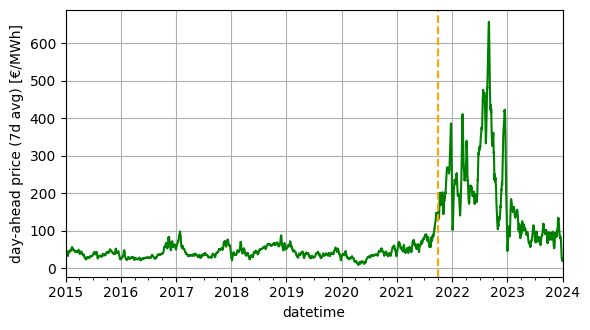

In [11]:
fig, ax = plt.subplots(figsize=(6, 3.4))
data['price_da'].rolling('7d').mean().plot(color='green')

date_to_be_marked = '2021-10-01 00:00:00' 
ax.axvline(pd.to_datetime(date_to_be_marked), color='orange', linestyle='--', label='cutoff date')

ax.set_xlabel('year')
ax.set_ylabel('day-ahead price (7d avg) [€/MWh]')

#ax.legend()

ax.grid(True)

plt.tight_layout()
plt.savefig('./plots/da_price_avg_alltime.svg')
plt.show()

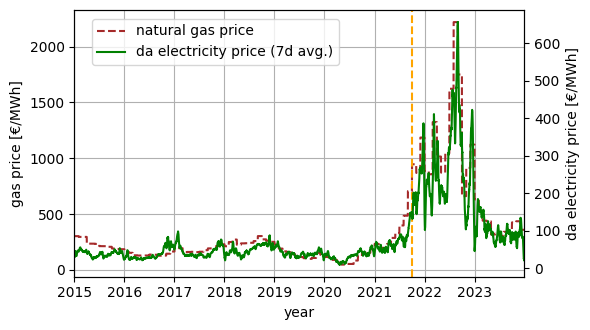

In [133]:
fig, ax1 = plt.subplots(figsize=(6, 3.4))

# Plotting the first data series on the primary y-axis
ax1.plot(data.index, data['gas_price'], color='brown', label='natural gas price', linestyle='dashed')
ax1.set_xlabel('year')
ax1.set_ylabel('gas price [€/MWh]', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Adding a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(data.index, data['price_da'].rolling('7d').mean(), color='green', label='da electricity price (7d avg.)')
ax2.set_ylabel('da electricity price [€/MWh]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

start_date='2015-01-01'
end_date='2023-12-31'
ax1.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Marking the cutoff date
date_to_be_marked = '2021-10-01 00:00:00' 
ax1.axvline(pd.to_datetime(date_to_be_marked), color='orange', linestyle='--')
fig.legend(loc='upper left', bbox_to_anchor=(0.15,0.95))
ax1.grid(True)
plt.tight_layout()
plt.savefig('./plots/da_price_avg_alltime.svg')
plt.show()

In [13]:
data['price_da'][:'2021-09-30'].mean()

43.77468111402692

In [14]:
data['price_da']['2021-10-01':].mean()

190.2823508540727

# Shapley Flow Plots

## load credit, models, etc.

In [16]:
# load credit flow and models from file
periods = [('2015-01-08', '2021-09-30'), # pre energy-crisis
                ('2021-10-01', '2023-12-31'), # energy crisis
                ('2015-01-08', '2023-12-31')] # full period
version = 'v5'
date = datetime.datetime.now().strftime("%Y-%m-%d")

# load xgb
xgb_creditflow_list = []
xgb_model_list = []
xgb_fg_list = []
for (start_date, end_date) in periods:
    cf_file_name = 'flow_xgb_start_{}_end_{}'.format(start_date, end_date, version)
    with open('./credit_flow/{}/{}.pkl'.format(version, cf_file_name), 'rb') as file:
        loaded_cf = dill.load(file)
        rename_nodes_in_graph_FR(loaded_cf)
        xgb_creditflow_list.append(loaded_cf)

    model = xgb.Booster()
    model_name = 'xgb_start_{}_end_{}_best'.format(start_date, end_date)
    model.load_model("./models/{}/{}.json".format(version, model_name))
    xgb_model_list.append(model)
    xgb_fg_list.append(read_csv_incl_timeindex('./data/{}/fg_xgb_start_{}_end_{}.csv'.format(version, start_date, end_date)))

# load fnn
layer_sizes = [(30, 15),
               (30, 15),
               (10, 15)]

fnn_creditflow_list = []
fnn_model_list = []
fnn_X_scalers = []
fnn_y_scalers = []
fnn_bg_list = []
fnn_fg_list = []

for i, (start_date, end_date) in enumerate(periods):
    model_name = 'pytorch_start_{}_end_{}'.format(start_date, end_date)
    cf_file_name = 'pytorch_start_{}_end_{}'.format(start_date, end_date, version)
    with open('./credit_flow/{}/{}.pkl'.format(version, cf_file_name), 'rb') as file:
        loaded_cf = dill.load(file)
        rename_nodes_in_graph_FR(loaded_cf)
        fnn_creditflow_list.append(loaded_cf)

    load_model = True
    if load_model:
        l1, l2 = layer_sizes[i]
        config = {
                    "input_size": 20,
                    "l1_size": l1,
                    "l2_size": l2,
                    "output_size": 1,
                    "learning_rate": 0.001,
                    "do": 0
                }
        model = PriceFNN(config)
        model.load_state_dict(torch.load("./models/{}/pytorch/best/model_{}_l1_{}_l2_{}.pkl".format(version, model_name, l1, l2)))
        model.eval()
        fnn_model_list.append(model)

        X_train = read_csv_incl_timeindex('./data/{}/X_train_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date))
        y_train = read_csv_incl_timeindex('./data/{}/y_train_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date))
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X_col = X_train.columns
        X_scaler = X_scaler.fit(X_train[X_col].values)
        fnn_X_scalers.append(X_scaler)
        y_col = y_train.columns
        y_scaler = y_scaler.fit(y_train[y_col].values)
        fnn_y_scalers.append(y_scaler)
    fnn_bg_list.append(read_csv_incl_timeindex('./data/{}/bg_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date)))
    fnn_fg_list.append(read_csv_incl_timeindex('./data/{}/fg_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date)))

## plot feature importance

In [61]:
df_feature_attr = pd.DataFrame()
for cf_list, model_name in zip([fnn_creditflow_list, xgb_creditflow_list],['FNN', 'XGB']):
    for i, period in enumerate(periods):
        start, end = period
        col_name = model_name + ' ' + start + ' to ' + end
        df_feature_attr[col_name] = get_mean_shap_attr(cf_list[i], 'Day-ahead price')
        df_feature_attr[col_name] = df_feature_attr[col_name]/df_feature_attr[col_name].max()

new_order = ['Month', 'Day of week', 'Day of year cos', 'Day of year sin', 'Hour cos', 'Hour sin',
    'Generation day-ahead', 'Load day-ahead', 'Solar day-ahead', 'Wind day-ahead',
    'Generation day-ahead ramp', 'Load day-ahead ramp', 'Solar day-ahead ramp', 'Wind day-ahead ramp',
    'Nuclear availability', 'Temperature', 'Temperature 7d avg.',
    'Gas price', 'Oil price', 'Carbon price']


df_feature_attr = df_feature_attr.reindex(new_order)

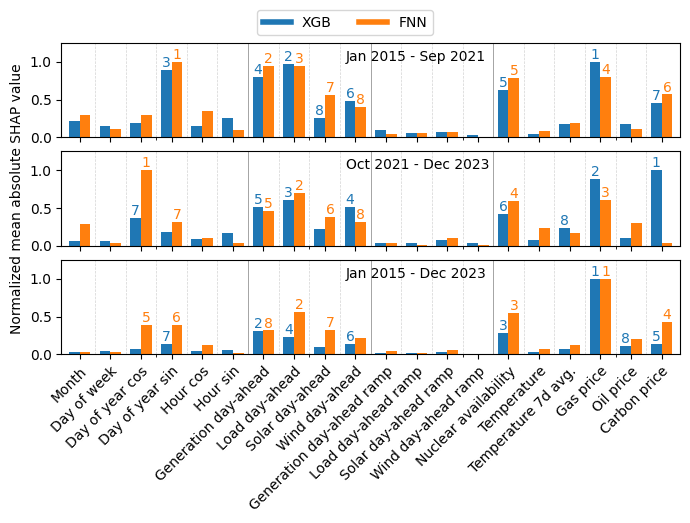

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

cols=[['XGB 2015-01-08 to 2021-09-30', 'FNN 2015-01-08 to 2021-09-30'],
      ["XGB 2021-10-01 to 2023-12-31", "FNN 2021-10-01 to 2023-12-31"],
      ['XGB 2015-01-08 to 2023-12-31', 'FNN 2015-01-08 to 2023-12-31']]
titles = ["Jan 2015 - Sep 2021", "Oct 2021 - Dec 2023", "Jan 2015 - Dec 2023"]

for i, ax in enumerate([ax1, ax2, ax3]):
    if i == 0:
        df_feature_attr[cols[i]].plot(kind='bar', ax=ax1, width=0.7)
        ax.set_xticklabels([])
    elif i == 1:
        df_feature_attr[cols[i]].plot(kind='bar', ax=ax2, width=0.7)
        ax.set_xticklabels([])
        ax.set_ylabel("Normalized mean absolute SHAP value")
    else:
        df_feature_attr[cols[i]].plot(kind='bar', ax=ax3, width=0.7)
        ax.set_xticklabels(df_feature_attr.index, rotation=45, ha='right', rotation_mode='anchor')
    #ax.set_xlabel("Features")
    #ax.set_yticklabels([])
    ax.legend(title="")
    ax.legend().remove()
    ax.set_ylim(0, 1.25)
    ax.text(0.46, 0.93, titles[i], transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')
    #ax.text(0, 1.25, titles[i], transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')


    num_features = 8
    for period in df_feature_attr.columns:
        top_features = df_feature_attr.nlargest(num_features, period)

        for feature_name in top_features.index:
            bar_index = list(df_feature_attr.index).index(feature_name)
            height = df_feature_attr.at[feature_name, period]
            feature_rank = top_features.index.get_loc(feature_name) + 1

            for container in ax.containers:
                if container.get_label() == period:
                    bar = container[bar_index]
                    bar_color = bar.get_facecolor()
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), feature_rank, 
                            color=bar_color, ha='center', va='bottom', rotation=0, rotation_mode='anchor')

    for i in range(len(df_feature_attr.index) - 1):
        if i in [5, 9, 13]:
            ax.axvline(x=i + 0.5, color='grey', linestyle='-', linewidth=0.5, clip_on=False)
        else:
            ax.axvline(x=i + 0.5, color='lightgrey', linestyle='--', linewidth=0.5)

handles = [plt.Line2D([0], [0], color='tab:blue', lw=4, label='XGB'),
           plt.Line2D([0], [0], color='tab:orange', lw=4, label='FNN')]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.15)

plt.savefig('./plots/compare_models_norm.pdf', bbox_inches='tight')


plt.show()

## local explanation example

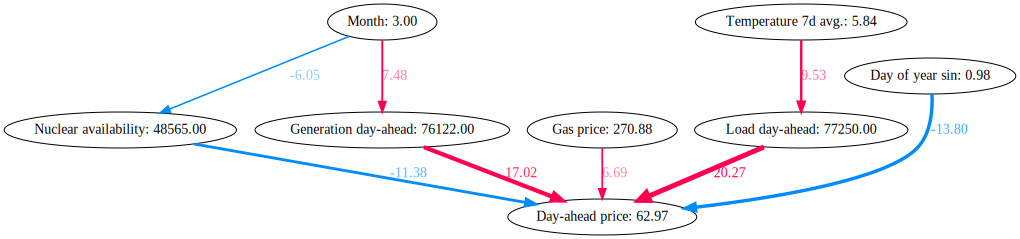

In [65]:
from shap_flow_util import save_graph_thesis
model_index = 0
max_display = 8
xgb_creditflow_list[model_index].fold_noise=True




g = xgb_creditflow_list[model_index].draw(idx=69,#100,32
                show_fg_val=True,
                max_display=max_display)

#g.graph_attr['fontsize'] = 20
#g.graph_attr.update(size='30,1!')

start_date, end_date = periods[model_index]
g.graph_attr['rankdir']='LR' # change layout from top-bottom to left-right
save_graph_thesis(g, './plots/local_explanation-{}_{}_{}_{}_index_{}'.format(max_display, start_date, end_date, model_index, 69), format='svg', view=True)

In [66]:
xgb_fg_list[model_index].mean()

carbon_price             55.122095
gas_price               208.953827
oil_price                87.127489
solar_da               1139.590000
wind_da                2934.916000
load_da               51969.317000
nuclear_avail         45027.587000
generation_da         59321.873000
temp_mean                14.794320
temp_mean_7d_avg         15.070874
solar_da_ramp            -8.422000
wind_da_ramp              2.419000
load_da_ramp             -4.657000
generation_da_ramp       28.363000
month                     6.424000
dayofyear_sin            -0.104947
dayofyear_cos            -0.087191
hour_sin                 -0.012605
hour_cos                  0.021276
day_of_week               3.073000
dtype: float64

# Visualization Foundations

In [52]:
data_picture = {
    'Shapley values': [0, 0, 0.6, 0.4],
    'ASV': [1.0, 0.0, 0.0, 0.0]
}
index = ['$X_1$', '$X_2$', '$X_3$', '$X_4$']
attributions = pd.DataFrame(data_picture, index=index)
attributions = attributions.sort_index(ascending=False)
attributions

,Shapley values,ASV
$X_4$,0.4,0.0
$X_3$,0.6,0.0
$X_2$,0.0,0.0
$X_1$,0.0,1.0


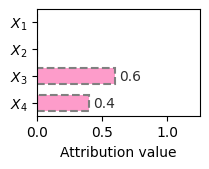

In [100]:
plt.figure(figsize=(2.2, 1.8))
bars = plt.barh(attributions.index, attributions['Shapley values'], color='#fd9cca', height=0.6, label='Attribution 1')
for bar in bars:
    bar.set_edgecolor('gray')
    bar.set_linestyle('--')
    bar.set_linewidth(1.5)
    width = bar.get_width()
    if width > 0:  # Only add text for non-zero values
        plt.text(width + 0.03, bar.get_y() + bar.get_height()/2, f'{width:.1f}', va='center', fontsize=10, color='#2f2f2f')
plt.xlim(0, 1.25)
plt.xlabel('Attribution value')
plt.tight_layout()
plt.savefig('./plots/feature_attribution_ex_shap.pdf')
plt.show()

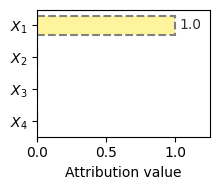

In [99]:
plt.figure(figsize=(2.3, 2))
bars = plt.barh(attributions.index, attributions['ASV'], color='#fff49e', height=0.6, label='Attribution 1')
for bar in bars:
    bar.set_edgecolor('gray')
    bar.set_linestyle('--')
    bar.set_linewidth(1.5)
    width = bar.get_width()
    if width > 0:  # Only add text for non-zero values
        plt.text(width + 0.03, bar.get_y() + bar.get_height()/2, f'{width:.1f}', va='center', fontsize=10, color='#2f2f2f')
plt.xlim(0, 1.25)
plt.xlabel('Attribution value')
plt.tight_layout()
plt.savefig('./plots/feature_attribution_ex_asv.pdf')
plt.show()